In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout


In [2]:
# Load the combined dataset (adjust file path as needed)
combined_data = pd.read_csv(r"C:\Users\Haripriya.R\Desktop\studies\SmartWindDashboard\data\cleaned_weather_data.csv")

# Check for missing values
combined_data.isnull().sum()

# Fill or drop missing values (example)
combined_data = combined_data.dropna()

# Ensure 'DATE' is in datetime format
combined_data['DATE'] = pd.to_datetime(combined_data['DATE'])

# Feature Engineering: Convert relevant features to a numerical format
# Example: Convert date into Month and Day if needed, otherwise use existing ones
combined_data['Month'] = combined_data['DATE'].dt.month
combined_data['Day'] = combined_data['DATE'].dt.day

# Select relevant features
features = ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'Month', 'Day', 'Humidity']

# Select target variable
target = 'WDSP'  # Example target (Wind Speed)
X = combined_data[features]
y = combined_data[target]


In [3]:
# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing datasets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [4]:
# Reshape data for GRU input: (samples, time steps, features)
# Since this is a univariate time series, we'll use 1 time step
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [5]:
# Build the GRU model
model = Sequential()

# Add GRU layer
model.add(GRU(units=64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

# Add another GRU layer
model.add(GRU(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Add Dense output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\Haripriya.R\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# Train the model
history = model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 34.6531 - val_loss: 51.4078
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 34.1844 - val_loss: 50.8999
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 33.8761 - val_loss: 50.3980
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 33.5727 - val_loss: 49.8962
Epoch 5/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 33.1223 - val_loss: 49.3920
Epoch 6/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - loss: 32.6274 - val_loss: 48.8836
Epoch 7/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 32.3592 - val_loss: 48.3685
Epoch 8/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 31.9099 - val_loss: 47.8447
Epoch 9/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 31.6566 - val_loss: 47.3104
Epoch 10/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 31.1739 - val_loss: 46.7627
Epoch 11/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 30.7853 - val_loss: 46.1989
Epoch 12/2000
1/1 ━━━━━━━━━━━━━

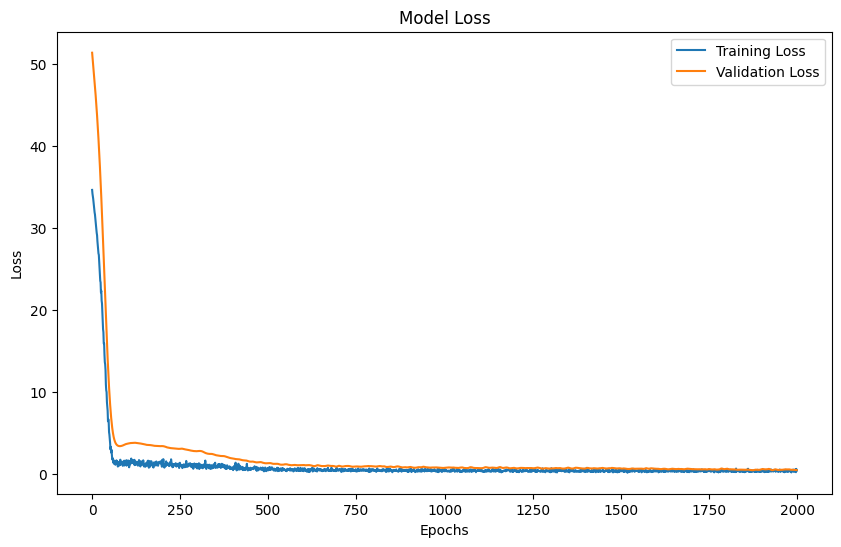

In [7]:
# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [8]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.4389
Test Loss: 0.4389345645904541


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step


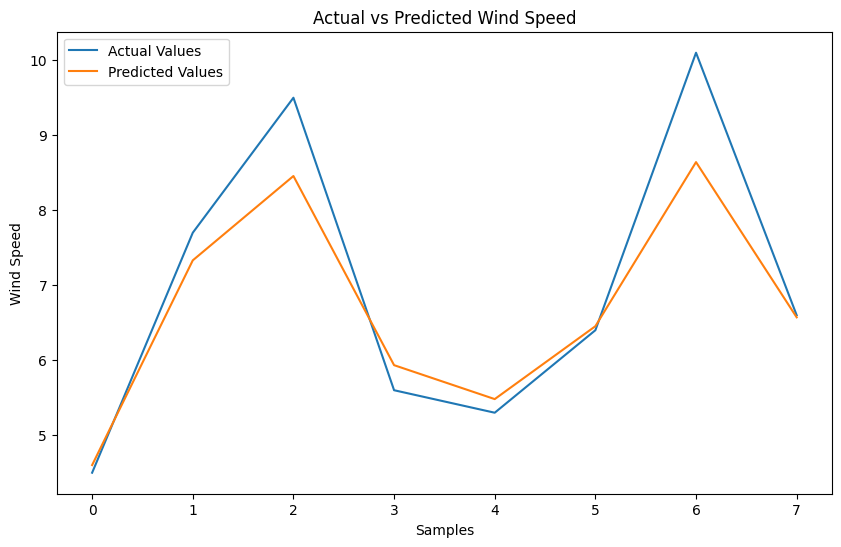

In [9]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Visualize predictions vs actual values
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Actual vs Predicted Wind Speed')
plt.xlabel('Samples')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()


In [10]:
# Save the trained model
model.save('gru_wind_speed_model1_2000.keras')


In [11]:
from sklearn.metrics import mean_squared_error, r2_score
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")


Mean Squared Error (MSE): 0.43893443326860726
R-squared (R²): 0.8744051337721157


Trial 90 Complete [00h 00m 33s]
val_loss: 4.7171735763549805

Best val_loss So Far: 2.0550642013549805
Total elapsed time: 00h 24m 59s

The optimal number of units for the first GRU layer is 112.
The optimal dropout rate for the first GRU layer is 0.4.
The optimal number of units for the second GRU layer is 64.
The optimal dropout rate for the second GRU layer is 0.30000000000000004.
The optimal optimizer is rmsprop.



C:\Users\Haripriya.R\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 34.4414 - val_loss: 48.9941
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 32.5240 - val_loss: 46.9071
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 30.8207 - val_loss: 44.9138
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 29.1807 - val_loss: 42.8392
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 27.7903 - val_loss: 40.7017
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 26.2144 - val_loss: 38.5095
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 24.4692 - val_loss: 36.2224
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 23.0366 - val_loss: 33.8891
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 21.2810 - val_loss: 31.5232
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 19.7120 - val_loss: 29.1513
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 18.2120 - val_loss: 26.8030
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

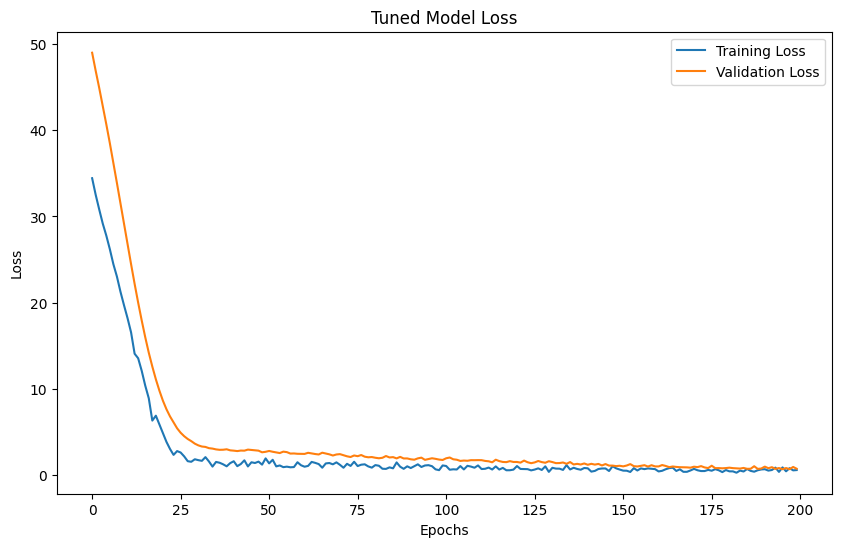

In [16]:
import keras_tuner as kt

# Define the model-building function
def build_model(hp):
    model = Sequential()
    
    # First GRU layer with tunable units and dropout
    model.add(
        GRU(
            units=hp.Int("units_gru1", min_value=32, max_value=128, step=16),
            input_shape=(X_train.shape[1], X_train.shape[2]),
            return_sequences=True,
        )
    )
    model.add(Dropout(hp.Float("dropout_gru1", min_value=0.1, max_value=0.5, step=0.1)))
    
    # Second GRU layer with tunable units and dropout
    model.add(
        GRU(
            units=hp.Int("units_gru2", min_value=16, max_value=64, step=16),
            return_sequences=False,
        )
    )
    model.add(Dropout(hp.Float("dropout_gru2", min_value=0.1, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(1))
    
    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=hp.Choice("optimizer", ["adam", "rmsprop"]),
        loss="mean_squared_error",
    )
    return model

# Initialize the Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=50,
    factor=3,
    directory="hyperparam_tuning",
    project_name="gru_wind_speed",
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

# Get the best hyperparameters and build the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of units for the first GRU layer is {best_hps.get('units_gru1')}.
The optimal dropout rate for the first GRU layer is {best_hps.get('dropout_gru1')}.
The optimal number of units for the second GRU layer is {best_hps.get('units_gru2')}.
The optimal dropout rate for the second GRU layer is {best_hps.get('dropout_gru2')}.
The optimal optimizer is {best_hps.get('optimizer')}.
""")

# Build the best model and train it
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), batch_size=32)

# Evaluate the best model
test_loss = best_model.evaluate(X_test, y_test)
print(f"Test Loss (Best Model): {test_loss}")

# Save the tuned model
best_model.save('gru_wind_speed_best_model.keras')

# Plot training and validation loss for the best model
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Tuned Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions using the best model after hyperparameter tuning
y_pred_tuned = best_model.predict(X_test)

# Flatten predictions and actual values for compatibility
y_pred_tuned = y_pred_tuned.flatten()
y_test_tuned = y_test.values.flatten()  # If y_test is a pandas Series

# Calculate MSE and R² for the tuned model
mse_tuned = mean_squared_error(y_test_tuned, y_pred_tuned)
r2_tuned = r2_score(y_test_tuned, y_pred_tuned)

# Print the results
print(f"Mean Squared Error (MSE) after hyperparameter tuning: {mse_tuned}")
print(f"R-squared (R²) after hyperparameter tuning: {r2_tuned}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Mean Squared Error (MSE) after hyperparameter tuning: 0.7456109309507859
R-squared (R²) after hyperparameter tuning: 0.7866540010692078


In [21]:
# Train the model with 2000 epochs
history = best_model.fit(X_train, y_train, epochs=2000, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - loss: 0.6813 - val_loss: 0.6593
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.5099 - val_loss: 0.6670
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.5586 - val_loss: 0.6243
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.4543 - val_loss: 0.6723
Epoch 5/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.4770 - val_loss: 0.8050
Epoch 6/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.7277 - val_loss: 0.6262
Epoch 7/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.5423 - val_loss: 0.6324
Epoch 8/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.5015 - val_loss: 0.8437
Epoch 9/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.7664 - val_loss: 0.6649
Epoch 10/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.6596 - val_loss: 0.6915
Epoch 11/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.5306 - val_loss: 0.6503
Epoch 12/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step

In [24]:
y_pred = best_model.predict(X_test)

# Flatten predictions and actual values for compatibility
y_pred = y_pred.flatten()
y_test_flat = y_test.values.flatten()  # Ensure y_test is a NumPy array or use .values to flatten a pandas Series

# Calculate MSE (Mean Squared Error)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_flat, y_pred)

# Calculate R-squared (R²)
from sklearn.metrics import r2_score
r2 = r2_score(y_test_flat, y_pred)

# Print the results
print(f"Mean Squared Error (MSE) after 2000 epochs: {mse}")
print(f"R-squared (R²) after 2000 epochs: {r2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mean Squared Error (MSE) after 2000 epochs: 0.3715680105749378
R-squared (R²) after 2000 epochs: 0.893681080713569


In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
model = load_model(r'C:\Users\Haripriya.R\Desktop\studies\SmartWindDashboard\models\gru_wind_speed_best_model.keras')


features = ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'Month', 'Day', 'Humidity']

new_data = {
    'LATITUDE': [12.994414],  # Example value from the dataset
    'LONGITUDE': [80.180517],  # Example value from the dataset
    'ELEVATION': [15.84],      # Example value from the dataset
    'TEMP': [78],              # Example temperature value from the dataset
    'DEWP': [68.7],            # Dew point
    'SLP': [1013.1],           # Sea level pressure
    'STP': [11.3],             # Station pressure
    'VISIB': [3.9],            # Visibility
    'WDSP':[0],
    'MXSPD': [9],              # Maximum speed
    'GUST': [3.3],             # Gust speed
    'MAX': [88.2],             # Maximum temperature
    'MIN': [68],               # Minimum temperature
    'PRCP': [0],               # Precipitation
    'Month': [1],              # January (Month 1)
    'Day': [1],                # Day 1
    'Humidity': [88.07692308]  # Example humidity value from the dataset
}

# Convert new data into a DataFrame
new_data_df = pd.DataFrame(new_data)
scaler=MinMaxScaler()
new_data_scaled = scaler.fit_transform(new_data_df)



# Reshape the input data to match the input shape of the GRU model
new_data_scaled = new_data_scaled.reshape((new_data_scaled.shape[0], 1, new_data_scaled.shape[1]))

# Now, you can make predictions with the model
predicted_wind_speed = model.predict(new_data_scaled)

# Flatten the predicted values and display the result
predicted_wind_speed_value = predicted_wind_speed.flatten()[0]
print(f"Predicted Wind Speed: {predicted_wind_speed_value}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
Predicted Wind Speed: 2.9649152755737305
